In [18]:
import os
import sys
import json
import pickle
import pandas as pd 
import matplotlib.pyplot as plt
from dna_features_viewer import GraphicFeature, GraphicRecord
sys.path.append(r'/davidb/yatirsolan/scripts/python/bio_utilities')
sys.path.append(r'/davidb/yatirsolan/thesis_work/figures/general')
import visual_utils
import gff_parser

Dictionary of the contig and its gff file path

In [19]:
working_directory = r'/davidb/yatirsolan/thesis_work/figures/T6SS_operons_representatives'
paths_file_json = r'/davidb/yatirsolan/thesis_work/figures/general/final_paths.json'
os.chdir(working_directory)

Declaring the group of intrest : 

In [20]:
actual_systems_df = pd.read_table(r'/davidb/yatirsolan/secretion_systems/T6SS/T6SSi_vs_Metagenomics/review_summary/T6SSi_min_core_prts.tsv')
gnrl_anlz_df = pd.read_table(r'/davidb/yatirsolan/secretion_systems/T6SS/T6SSi_vs_Metagenomics/review_summary/T6SSi_gnrl_anlyz.tsv')
sys_dstrb = pickle.load(open(json.load(open(paths_file_json)).get('T6SS').get('system_distribution'),'rb'))
poss_df = pd.read_table(json.load(open(paths_file_json)).get('T6SS').get('possession_dataframe'))
cntg_gff_path_dic = visual_utils.gff_paths(r'/davidb/yatirsolan/secretion_systems/T6SS/T6SSi_vs_Metagenomics/review_summary/T6SSi.report')
mtdta_dic = {k:v for k,v in pd.read_table(json.load(open(paths_file_json)).get('tree_metadata_family')).loc[:,['rnk_txn', 'phyla_class']].values}

poss_df['phyla_class'] = poss_df.rnk_txn.apply(lambda x: mtdta_dic.get(x))
poss_df = poss_df[poss_df.possession!='none']
poss_df.drop('possession', axis=1, inplace=True)
poss_df.sort_values(by=['system', 'phyla_class'],ascending=[True, True],inplace=True)
possession_dictionary = {tpe:{phy_cla:list(sub_sub_df.rnk_txn) for phy_cla, sub_sub_df in sub_df.groupby('phyla_class')} for tpe, sub_df in poss_df.groupby('system')}

dict_for_df = {'type':list(), 'phyla_class':list(), 'leaf':list(), 'contig':list(), 'display':list()}

leaves_lst = [('Chlorobiaceae', 'Prosthecochloris_sp.|SAMN10135560|GCA_004028745.1|RAZP01000067.1', 'Prosthecochloris_sp.'), 
              ('Ignavibacteriaceae', 'activated_sludge_metagenome|SAMN05720209|GCA_900245005.1|OFEK01000055.1', 'Ignavibacteriaceae'), 
              ('Synergistaceae', 'uncultured_Cloacibacillus_sp.|SAMEA4891463|GCA_900545755.1|URAG01000022.1', 'Synergistaceae'), 
              ('Nitrospinaceae', '3300009703_GEM_Ga0114933_ctg_10000021', 'Nitrospinaceae')] 

for leaf, contig, display in leaves_lst:
    dict_for_df.get('type').append('T6SSi')
    dict_for_df.get('phyla_class').append(mtdta_dic.get(leaf))
    dict_for_df.get('leaf').append(leaf)
    dict_for_df.get('contig').append(contig)
    dict_for_df.get('display').append(display)

def arrange_species_name(species):
    species_lst = species.split()
    species_name = ' '.join(species_lst[:2:])
    return species_name

rpr_df = pd.DataFrame.from_dict(dict_for_df)
rpr_df.sort_values(by=['phyla_class'], ascending=[True], inplace=True)
rpr_df.reset_index(inplace=True, drop=True)
contigs_of_intrest = rpr_df.contig.to_list()
rpr_df

,type,phyla_class,leaf,contig,display
0,T6SSi,Chlorobi,Chlorobiaceae,Prosthecochloris_sp.|SAMN10135560|GCA_00402874...,Prosthecochloris_sp.
1,T6SSi,Ignavibacteriae,Ignavibacteriaceae,activated_sludge_metagenome|SAMN05720209|GCA_9...,Ignavibacteriaceae
2,T6SSi,Nitrospinae,Nitrospinaceae,3300009703_GEM_Ga0114933_ctg_10000021,Nitrospinaceae
3,T6SSi,Synergistetes,Synergistaceae,uncultured_Cloacibacillus_sp.|SAMEA4891463|GCA...,Synergistaceae


Extracting all the orfs out of the general analyzer file

In [21]:
cntg_mtchs_dic, cntg_orfs_dic = visual_utils.contig_survey_general(contigs_of_intrest, gnrl_anlz_df)

In [22]:
box_colors_dic = {'T6SSi':'#b2182b', 'T6SSii':'#ba36e3', 'T6SSiii':'#1f78b4'}
box_colors_dic = {cntg:box_colors_dic.get(type) for cntg, type in rpr_df.loc[:, ['contig', 'type']].values}

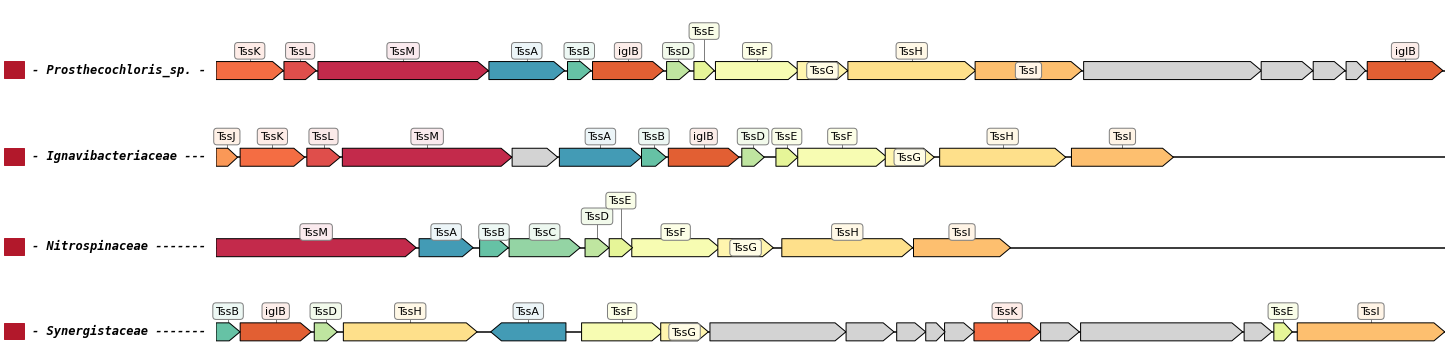

In [23]:
colors_dic = visual_utils.colors_palletes('T6SS')
systems, operon_lngth_dic = list(), dict()
for contig in contigs_of_intrest:
    if len(cntg_mtchs_dic.get(contig)) < 10 :
        continue
    features = list()
    orfs = gff_parser.main(cntg_gff_path_dic.get(contig)).get(contig)
    first_match = cntg_mtchs_dic.get(contig)[0]
    last_match = cntg_mtchs_dic.get(contig)[-1]
    diagram_start, diagram_end, offset_inside, inside, out = None, None, False, False, False
    first_offset, last_offset = visual_utils.index_with_offset(orfs, first_match, last_match, offset=0)
    contig_orfs_name_gen = (('#','#') if name == '#' else (name.split('$')[1].split('_')[0], name.split('$')[1]) 
                                                  for name in cntg_orfs_dic.get(contig))
    
    for orf in orfs:
        if orf.get('id') == first_match:
            offset_inside, inside = True, True
            if not diagram_start:
                diagram_start = orf.get('start')
        if inside:
            name, name_for_color = next(contig_orfs_name_gen)
            if name == '#' :
                lbl = '#'
                col = colors_dic.get(name_for_color)
            else:
                lbl = name
                col = colors_dic.get(name_for_color)
            if orf.get('id') == last_match:
                inside = False
        else:
            if orf.get('id') == first_offset or offset_inside:
                offset_inside = True
                if not diagram_start:
                    diagram_start = orf.get('start')
                lbl = '#'
                col = colors_dic.get('#')
        if orf.get('id') == last_offset:
            out = True
        if offset_inside:
            features.append(GraphicFeature(start = orf.get('start'),
                                           end = orf.get('end'),
                                           strand = visual_utils.st(orf.get('strand')),
                                           color = col if col else 'white',
                                           label = None if lbl=='#' else lbl,
                                           label_link_color = 'black',
                                           thickness = 18))                     
        if out:
            diagram_end = orf.get('end')
            break
    operon_lngth_dic[contig] = diagram_end-diagram_start
    if contig in visual_utils.reversed_contigs():
        for i in features:
            i.start = i.start*(-1)
            i.end = i.end*(-1)
            diagram_start = diagram_end*-1       
    systems.append([contig, features, diagram_start])   
mx = max(operon_lngth_dic.values())

fig, diagrams = plt.subplots(nrows=len(systems), ncols=1, figsize=(20, 5), sharex=False)

for (contig, features, start), diagram, in zip(systems, diagrams):
    type, phylum, leaf, = [(a, b, c) for a, b, c in rpr_df[rpr_df.contig == contig].loc[:, ['type', 'phyla_class', 'leaf']].values][0]
    type, phylum, display, = [(a, b, c) for a, b, c in rpr_df[rpr_df.contig == contig].loc[:, ['type', 'phyla_class', 'display']].values][0]

    diagram.annotate(text='  ', xy=(0,0), xytext=(-.17,-.08), xycoords=diagram.get_yaxis_transform(), 
                     bbox=dict(boxstyle='Square', facecolor=box_colors_dic.get(contig), edgecolor=box_colors_dic.get(contig)), 
                     fontsize=11, fontfamily='monospace', fontweight='bold', fontstyle='normal', color='white')

    diagram.annotate(text=f'- {display} '.ljust(24, '-'), xy=(0,0), xytext=(-.15,-.08), xycoords=diagram.get_yaxis_transform(), fontsize=12, fontfamily='monospace', fontweight='bold', fontstyle='italic')

    graphic_record = GraphicRecord(sequence_length=mx,
                                   first_index=start,
                                   features=features,
                                   ticks_resolution='auto',
                                   feature_level_height=0,
                                   labels_spacing=1)
    graphic_record.determine_annotation_height = lambda _ : .8

    graphic_record.plot(ax=diagram, 
                        draw_line=True, 
                        annotate_inline=False, 
                        with_ruler=False)
plt.tight_layout()
fig.savefig('figure5_d.svg',bbox_inches='tight')
fig